In [60]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **IMPORTING LIBRARIES**

In [61]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
import math
import matplotlib.pyplot as plt
import random
import torchvision
from torch import nn
from torch.nn import functional as F
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import InterpolationMode
import numpy as np
import scipy.ndimage
import skimage.color
import skimage.io
import skimage.transform
import os
from PIL import Image
from matplotlib import image as mpimg
import torchvision.transforms.functional
from torchvision.utils import draw_segmentation_masks
import copy
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights
from torchvision.transforms.functional import InterpolationMode
from torchvision.models import MobileNet_V2_Weights
from torchsummary import summary
from torch import optim

In [62]:
import copy
from pathlib import Path
from PIL import Image
import PIL
from pandas.core.common import flatten
import os
import shutil
import time
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler

In [63]:
#data path
data_dir = '/content/drive/MyDrive/PascalVOC/'

In [64]:
#data normalization and resizing
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224)),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

### **LOADING CUSTOM DATASET**

In [65]:
#Reference: https://towardsdatascience.com/how-to-use-datasets-and-dataloader-in-pytorch-for-custom-text-data-270eed7f7c00
class SegmentationPascal(Dataset):
  def __init__(self,data_dir,phase,transform=None):
    self.phase=phase
    #for training phase
    if phase=='train':
      self.transform=transform
      self.dir_image= data_dir + 'trainval/Images'
      self.dir_mask = data_dir+ 'trainval'
      self.masks_list= open(data_dir+ 'trainval'+ '/train.txt').readlines()
      self.dir_mask = data_dir + 'trainval/Annotations/'
    
    #for validation phase
    elif phase=='val':
      self.transform=transform
      self.dir_image= data_dir + 'trainval/Images'
      self.dir_mask = data_dir+ 'trainval'
      self.masks_list= open(data_dir+ 'trainval'+ '/val.txt').readlines()
      self.dir_mask = data_dir + 'trainval/Annotations/'

   
    #for testing phase
    else:
      self.transform=transform
      self.dir_image= data_dir + 'test/Images'
      self.dir_mask = data_dir + 'test/Annotations/'
      self.masks_list = os.listdir(self.dir_mask)

  def __len__(self):
    #return number of images in whatever phase we are operating
    return len(self.masks_list)

  def __getitem__(self, ind):
    #This function is used by Pytorch’s Dataset module to get a sample and construct the dataset
    if self.phase == 'test':
      path_for_mask = os.path.join(self.dir_mask+ self.masks_list[ind])
      image_path = os.path.join(self.dir_image, self.masks_list[ind].replace('.png', '.jpg'))
    if self.phase != 'test':
      path_for_mask = os.path.join(self.dir_mask, self.masks_list[ind].replace('\n', '.png'))
      image_path = os.path.join(self.dir_image, self.masks_list[ind].replace('\n', '.jpg'))
    image = Image.open(image_path).convert("RGB")
    mask = Image.open(path_for_mask)
    new_tensor = transforms.PILToTensor()
    mask = new_tensor(mask)
    if self.transform != None:
      image = self.transform(image)
      mask = transforms.Resize((520,520), interpolation=InterpolationMode.NEAREST)(mask)  
    return image, mask

    

### **LOADING DATA USING DATA LOADER**

In [66]:
image_datasets = {x: SegmentationPascal(data_dir, x, data_transforms) for x in ['train', 'val', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = 32, shuffle = True, num_workers = 2) for x in ['train', 'val']}

dataloaders_test= {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = 1, shuffle = False, num_workers = 2) for x in ['test']}

dataset_sizes = {x :len(image_datasets[x]) for x in ['train', 'val', 'test']}

In [67]:
print(dataset_sizes)

{'train': 209, 'val': 213, 'test': 210}


In [68]:
def bilinear_kernel(in_channels, out_channels, kernel_size):
  #To initialze weights for convolution layers
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = (torch.arange(kernel_size).reshape(-1, 1),
          torch.arange(kernel_size).reshape(1, -1))
    filt = (1 - torch.abs(og[0] - center) / factor) * \
           (1 - torch.abs(og[1] - center) / factor)
    weight = torch.zeros((in_channels, out_channels,
                          kernel_size, kernel_size))
    for i in range(out_channels):
        for j in range(in_channels):
            if i == j:
                weight[i, j, :, :] = filt
    return weight

In [69]:
class Mobilenetv2FCN(torch.nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    model = torchvision.models.mobilenet_v2(weights = MobileNet_V2_Weights.IMAGENET1K_V1)
    model = nn.Sequential(*list(model.children())[:-1])
    for param in model.parameters():
            param.requires_grad = False
  
    self.layer1=nn.Sequential(
        nn.ConvTranspose2d(1280,512, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
    )
    self.layer2=nn.Sequential(
        nn.ConvTranspose2d(512,256,kernel_size=4,stride=2,padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
    )
    self.layer3=nn.Sequential(
        nn.ConvTranspose2d(256,128,kernel_size=4,stride=2,padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
    )
    self.layer4=nn.Sequential(
        nn.ConvTranspose2d(128,64,kernel_size=4,stride=2,padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
    )
    self.layer5=nn.Sequential(
        nn.ConvTranspose2d(64,21,kernel_size=4,stride=2,padding=1),
        nn.BatchNorm2d(21),
        nn.ReLU(),
    )
    W1 = bilinear_kernel(1280, 512, 4)
    W2 = bilinear_kernel(512, 256, 4)
    W3 = bilinear_kernel(256, 128, 4)
    W4 = bilinear_kernel(128, 64, 4)
    W5 = bilinear_kernel(64, 21, 4)

    self.layer1[0].weight.data.copy_(W1)
    self.layer2[0].weight.data.copy_(W2)
    self.layer3[0].weight.data.copy_(W3)
    self.layer4[0].weight.data.copy_(W4)
    self.layer5[0].weight.data.copy_(W5)

    self.model = model

  def forward(self, x): #forward function
    out = self.model(x)
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = self.layer5(out)
    return out



In [70]:
model=Mobilenetv2FCN(21).to(device)
#model.eval()


### **MODEL SUMMARY**

In [71]:
from torchsummary import summary
summary(model,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

### **MODEL CRITERIA**

In [72]:
criterion=nn.CrossEntropyLoss(ignore_index=255) #cross entropy loss
optimizer_ft=optim.SGD(model.parameters(),lr=0.001,momentum=0.9)  #SGD optimizer
exp_lr_scheduler=lr_scheduler.StepLR(optimizer_ft,step_size=7,gamma=1)  #exp_lr_scheduler with 0% depreciation(gamma=1)

### **TRAINING THE MODEL**

In [73]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, masks in dataloaders[phase]:
                inputs = inputs.to(device)
                masks = masks.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    masks = masks.clone().squeeze().detach().long()
                    outputs = outputs.type(torch.float64)
                    #print(outputs.shape)
                    #print(masks.shape)


                    loss = criterion(outputs, masks)



                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / (dataset_sizes[phase])
            
            print('{} Loss: {:.16f}'.format(phase, epoch_loss))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [74]:
model=train_model(model,criterion,optimizer_ft,exp_lr_scheduler,num_epochs=500)

Epoch 0/499
----------
train Loss: 3.7519288340168333
val Loss: 3.7136096972261936

Epoch 1/499
----------
train Loss: 3.6976694620852681
val Loss: 3.8801825827862095

Epoch 2/499
----------
train Loss: 3.6209161143608228
val Loss: 3.9753944909202481

Epoch 3/499
----------
train Loss: 3.5203413772319010
val Loss: 3.9319484961388640

Epoch 4/499
----------
train Loss: 3.3939514153918524
val Loss: 3.7815926434065843

Epoch 5/499
----------
train Loss: 3.2601009799250575
val Loss: 3.5909887958001789

Epoch 6/499
----------
train Loss: 3.1242238381200012
val Loss: 3.4162936667725914

Epoch 7/499
----------
train Loss: 3.0253663498791088
val Loss: 3.2634114225824287

Epoch 8/499
----------
train Loss: 2.9618451724131418
val Loss: 3.1650256358869013

Epoch 9/499
----------
train Loss: 2.9142885433313128
val Loss: 3.0901113695572184

Epoch 10/499
----------
train Loss: 2.8811173261678400
val Loss: 3.0430372926313081

Epoch 11/499
----------
train Loss: 2.8491686276399566
val Loss: 3.00373685

In [75]:
def get_accuracy(outputs,labels):
  #this function calculates pixel wise accuracy for each test image 
  accuracies=[]
  total_pixels=outputs[0].shape[0]*outputs[0].shape[1]
  for i in range(len(outputs)):
    correct_count=0
    for j in range(outputs[0].shape[0]):
      for k in range(outputs[0].shape[1]):
        if (outputs[i][j][k]==labels[i][j][k]):  #checking if each pixel is matched or not
          correct_count+=1
    accuracy=correct_count/total_pixels #accuracy of each test image
    accuracies.append(accuracy) #collecting all test image accuracies in list
  print('Overall Average Accuracy is:')
  print((np.sum(accuracies)/len(outputs))*100)  #printing average accuracy

In [76]:
def get_MeanIOU(outputs,labels,dataset_sizes,classes):
  #this function calculates average MEAN IOU for test set
  IOUs = []
  for j in range(dataset_sizes['test']):
    IOU_sum = 0
    for i in range(classes):  #traversing all 21 classes for each image
      class_arr = np.full(outputs[0].shape, i)
      mask_class = class_arr == labels[j]
      output_class = class_arr == outputs[j]
      intersection = np.logical_and(mask_class, output_class)  #intersection
      class_intersection=np.sum(intersection)
      union = np.logical_or(mask_class, output_class) #union
      class_union=np.sum(union)
      if class_union != 0:
        IOU_sum += class_intersection * 100 / class_union
      else:
        IOU_sum += 100
        
    IOUs.append(IOU_sum / classes)  #IOU for each image = Mean IOU for 21 classes

  print('Overall MeanIOU : ', sum(IOUs)/ len(IOUs))  #Average IOU for all test data

### **TESTING THE MODEL ON TEST DATA**

In [77]:
def model_test(model,dataloaders_test):
  model.eval()
  model = model.to(device)
  outputs = []
  labels = []
  with torch.no_grad():
    for inputs, masks in dataloaders_test['test']: #traversing over test data
      inputs = inputs.to(device)
      outputs.append(torch.squeeze(model(inputs).argmax(1)).cpu().numpy()) #collecting all output images in 'outputs' list
      labels.append(torch.squeeze(masks).numpy())
  get_accuracy(outputs,labels) 
  get_MeanIOU(outputs,labels,dataset_sizes,21)

In [78]:
model_test(model,dataloaders_test)

Overall Average Accuracy is:
71.35626404579689
Overall MeanIOU :  81.14429013466703


### **PALETTE FOR MATCHING CLASS VALUE TO RGB ARRAY**

In [79]:
#palette is used for matching class value to RGB pixel
PALETTE = np.array(
    [
        [0, 0, 0] , # background
        [128, 0, 0], # aeroplane
        [0, 128, 0], # bicycle
        [128, 128, 0], # bird
        [0, 0, 128], # boat
        [128, 0, 128],  # bottle
        [0, 128, 128], # bus 
        [128, 128, 128], # car
        [64, 0, 0], # cat
        [192, 0, 0], # chair
        [64, 128, 0],  # cow
        [192, 128, 0], # dining table
        [64, 0, 128], # dog
        [192, 0, 128], # horse
        [64, 128, 128], # motorbike
        [192, 128, 128], # person
        [0, 64, 0], # potted plant
        [128, 64, 0], # sheep
        [0, 192, 0], # sofa
        [128, 192, 0], # train
        [0, 64, 128], # tv/monitor
    ]
    + [[0, 0, 0] for i in range(256 - 22)]
    + [[255, 255, 255]],
    dtype=np.uint8,
)

In [80]:
def AddPalette(array):
    pil_out = Image.fromarray(array.astype(np.uint8), mode='P')
    pil_out.putpalette(PALETTE)
    return pil_out

### **VISUALIZING MODEL OUTPUTS ON TEST DATA**


In [97]:
def visualize_model(model, num_of_images,custom_test_image=None):
  #This is written for visualization outputs for test4 and test5 images as well as test data
  model.eval()
  if custom_test_image!=None: #for custom test image(test4 and test5)
    image = torch.unsqueeze(custom_test_image, dim = 0)
    image = image.to(device,dtype=torch.float)
    output_mask = torch.squeeze(model(image).argmax(1)).cpu().numpy()
    image = torch.squeeze(image)
    output_mask = AddPalette(output_mask)
    invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                    std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                              transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                    std = [ 1., 1., 1. ]),
                              ])
    image = invTrans(image)
    fig, axis = plt.subplots(ncols = 2, squeeze = False, figsize = (15,15))
    axis[0,0].imshow(image.cpu().numpy().transpose(1,2,0))
    axis[0,1].imshow(output_mask)
    
    axis[0,0].title.set_text('Original Image')
    axis[0,1].title.set_text('FCN segmented Annotation')
  
    plt.show()
    return

  with torch.no_grad(): #for test data of pascal VOC
    Image_index = random.sample(range(dataset_sizes['test']), num_of_images)
    for i in Image_index:
      image, mask = image_datasets['test'][i]
      image = torch.unsqueeze(image, dim = 0)
      image = image.to(device,dtype=torch.float)
      output_mask = torch.squeeze(model(image).argmax(1)).cpu().numpy()
      image = torch.squeeze(image)
      mask = torch.squeeze(mask)
      mask = AddPalette(mask.numpy())
      output_mask = AddPalette(output_mask)
      invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])
      image = invTrans(image)
      fig, axis = plt.subplots(ncols = 3, squeeze = False, figsize = (15,15))
      axis[0,0].imshow(image.cpu().numpy().transpose(1,2,0))
      axis[0,1].imshow(output_mask)
      axis[0,2].imshow(mask)
      axis[0,0].title.set_text('Original Image')
      axis[0,1].title.set_text('FCN segmented Annotation')
      axis[0,2].title.set_text('Ground truth Annotation')
      plt.show()
    return

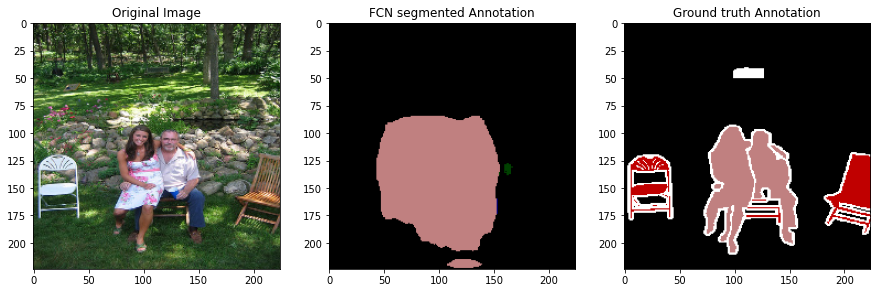

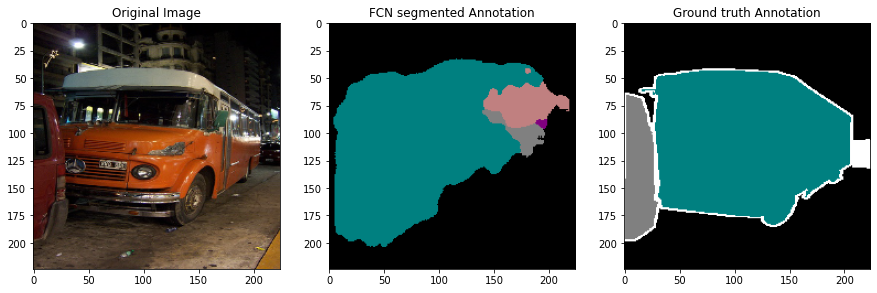

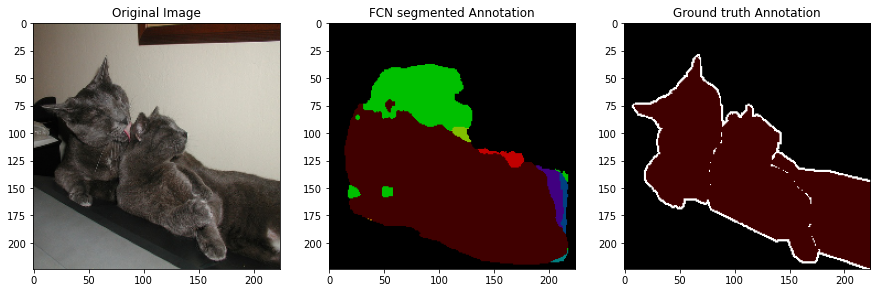

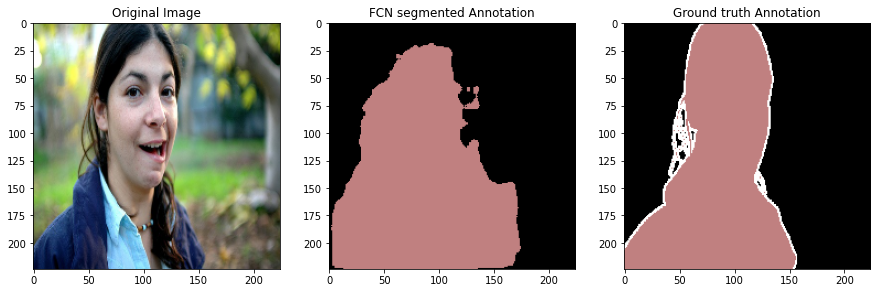

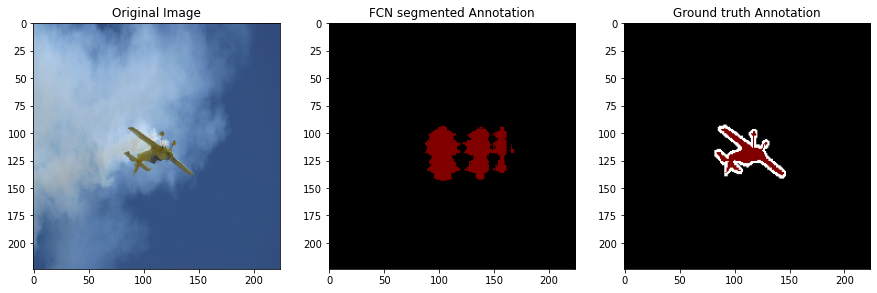

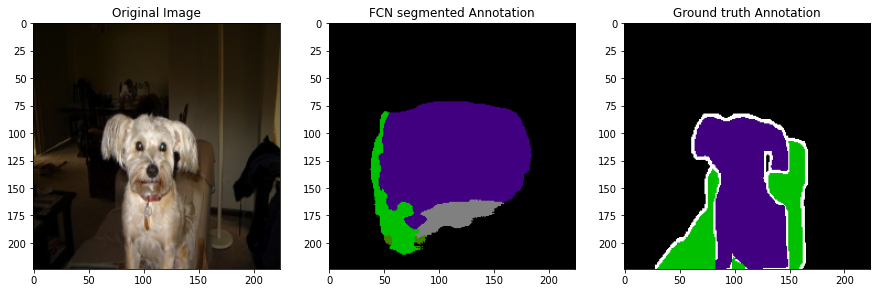

In [82]:
visualize_model(model, 6)

### **FCN on test4 and test5 Images given**

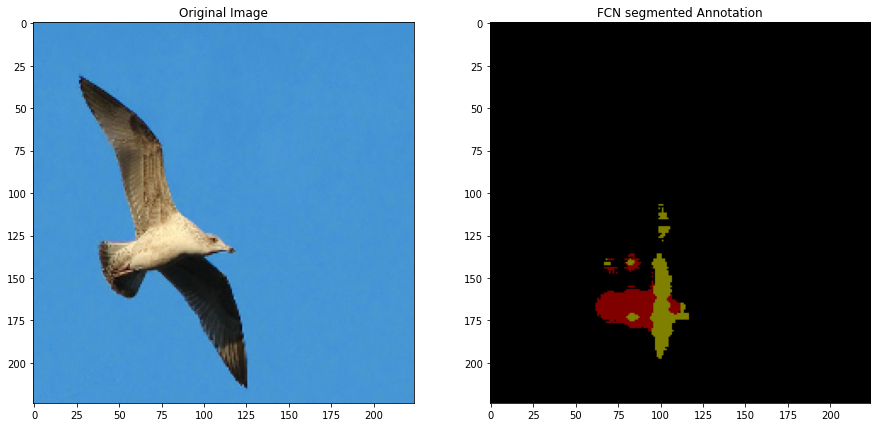

In [95]:
image=skimage.io.imread('test4.jpg')
image=data_transforms(image)    #applying transforms on test4.jpg
visualize_model(model, 6,image)


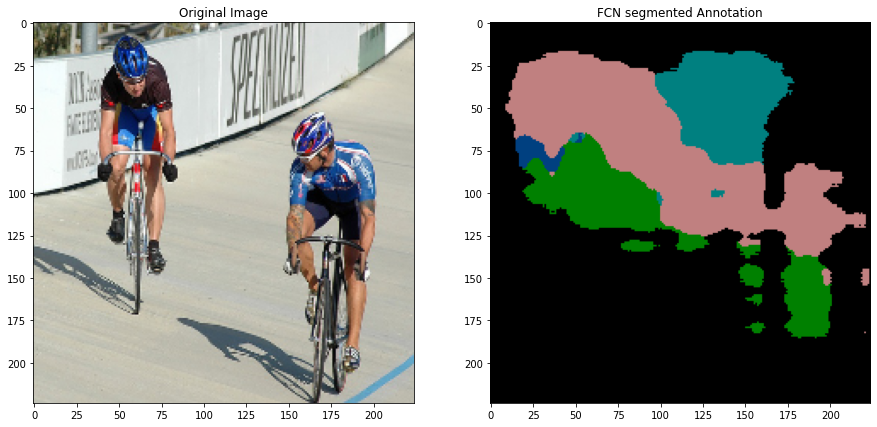

In [84]:
image=skimage.io.imread('test5.jpg')
image=data_transforms(image)    #applying transforms on test4.jpg
visualize_model(model, 6,image)


### **ROTATING TEST IMAGES**

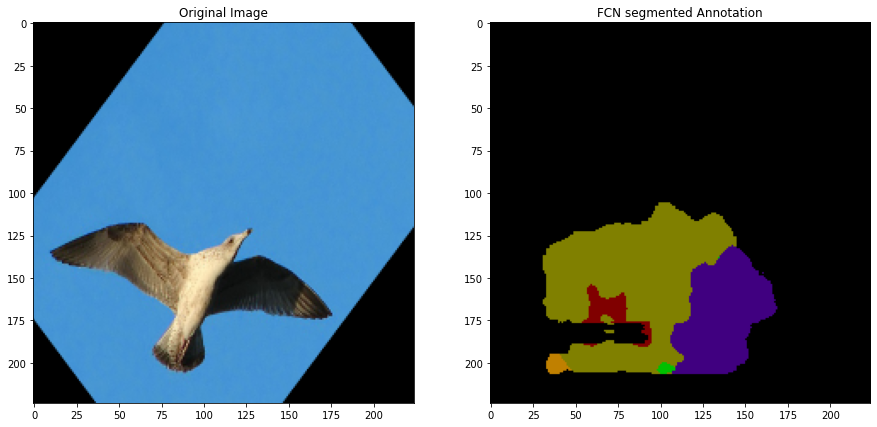

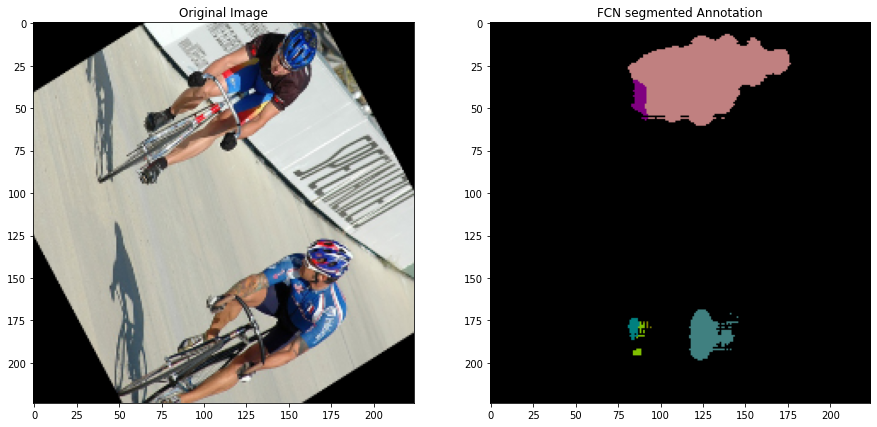

In [116]:
image=skimage.io.imread('test4.jpg')
image = skimage.transform.rotate(image, 45) #rotation
image=data_transforms(image)    #applying transforms on test4.jpg
visualize_model(model, 6,image)
image=skimage.io.imread('test5.jpg')
image = skimage.transform.rotate(image,-60) #rotation
image=data_transforms(image)    #applying transforms on test5.jpg
visualize_model(model, 6,image)

### **ADDING GAUSSIAN NOISE TO TEST IMAGES**

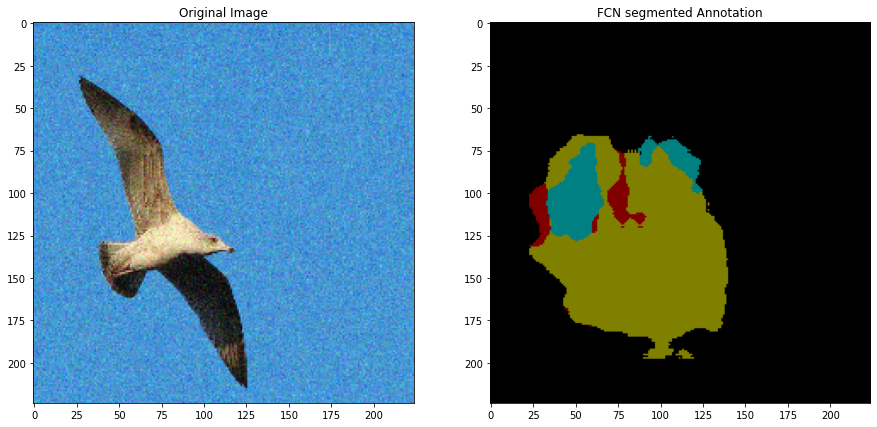

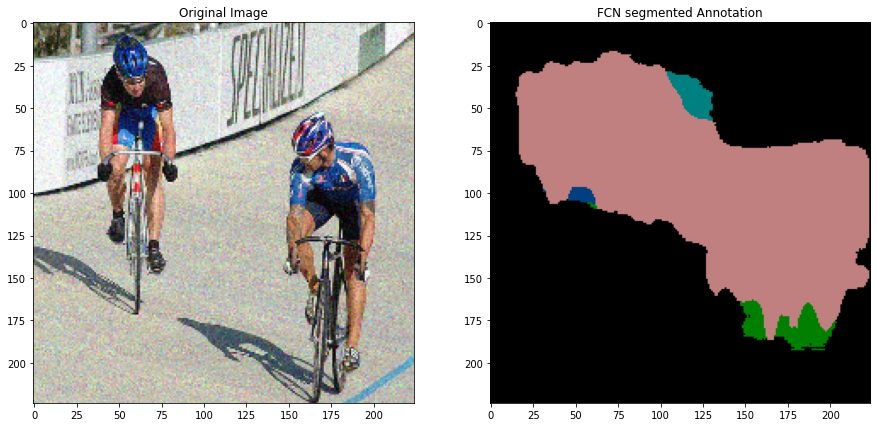

In [113]:
image=skimage.io.imread('test4.jpg')
image = skimage.util.random_noise(image, mode='gaussian') #gaussian noise
image=data_transforms(image)    #applying transforms on test4.jpg
visualize_model(model, 6,image)
image=skimage.io.imread('test5.jpg')
image = skimage.util.random_noise(image, mode='gaussian') #gaussian noise
image=data_transforms(image)    #applying transforms on test5.jpg
visualize_model(model, 6,image)